<center><img src=picture_1.jpg width=800px height=10%>

# Проект: классификация

Данные о клиентах банка:

- **age (возраст);**
- **job (сфера занятости);**
- **marital (семейное положение);**
- **education (уровень образования);**
- **default (имеется ли просроченный кредит);**
- **housing (имеется ли кредит на жильё);**
- **loan (имеется ли кредит на личные нужды);**
- **balance (баланс).**

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- **contact (тип контакта с клиентом);**
- **month (месяц, в котором был последний контакт);**
- **day (день, в который был последний контакт);**
- **duration (продолжительность контакта в секундах).**

Прочие признаки:
- **campaign (количество контактов с этим клиентом в течение текущей кампании);**
- **pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);**
- **previous (количество контактов до текущей кампании)**
- **poutcome (результат прошлой маркетинговой кампании).**

И, разумеется, наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [1]:
# Прогружаем все необходимые библиотеки для дальнейшей работы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
# Записываем в переменную наш датасет
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [5]:
# Обработайте данные этого признака так, чтобы он был преобразован в тип float.
df['balance']=df['balance'].str.replace('$','')
df['balance']=df['balance'].str.replace(',','.')
df['balance']=df['balance'].str.replace(' ','').astype('float')



### Задание 4

In [6]:
# Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.
print(df['balance'].mean().round(3))

1529.129


In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.loc[df['balance'].isnull(),'balance']=df['balance'].median()

In [8]:
print(df['balance'].mean().round(3))

1526.936


### Задание 5

In [9]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.loc[(df['education']=='unknown')  , 'education'] = df['education'].mode()[0]
df.loc[(df['job']=='unknown') , 'job'] = df['job'].mode()[0]

In [11]:
#Рассчитать средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования. Ответ округлите до трёх знаков после точки-разделителя.

print(df[(df['job']==df['job'].mode()[0]) & (df['education']==df['education'].mode()[0])]['balance'].mean().round(3))

1598.883


### Задание 6

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха (Q1 - 1.5* IQR) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (Q3 + 1.5* IQR). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

In [12]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(f'Нижняя граница: {lower_bound}' )
    upper_bound = quartile_3 + (iqr * 1.5)
    print(f'Верхняя граница: {upper_bound}')
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr(df, 'balance')
df_non_emissions=cleaned
display(f'Осталось объектов в новом датасете: {df_non_emissions.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0


'Осталось объектов в новом датасете: 10105'

## Часть 2:  Разведывательный анализ

### Задание 1

Рассмотрим сколько уникальных значений в каждом столбце.

In [13]:
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in df_non_emissions.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, df_non_emissions[col].nunique(),df_non_emissions[col].dtypes)     # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

,Column_Name,Num_Unique,Type
0,deposit,2,object
1,loan,2,object
2,housing,2,object
3,default,2,object
4,contact,3,object
5,marital,3,object
6,education,3,object
7,poutcome,4,object
8,job,11,object
9,month,12,object


deposit
no     5424
yes    4681
Name: count, dtype: int64
deposit
no     54.0
yes    46.0
Name: proportion, dtype: float64


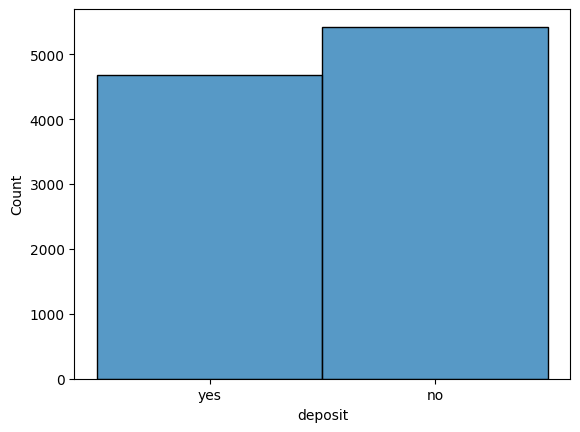

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.histplot(df_non_emissions['deposit']);
print(df_non_emissions['deposit'].value_counts())
print((df_non_emissions['deposit'].value_counts(normalize=True)* 100).round())


Целевой признак не сбалансирован, т.к. разница между ними 8%. Хотя разница не критичная.

### Задания 2 и 3

In [15]:
df_non_emissions.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


In [16]:
# Запишем отдельно наши числовые признаки и категориальные в отдельные списки
numerical_features=[]
categorical_features=[]
for col in df_non_emissions.columns:
    if  df_non_emissions[col].dtype != 'object':
        numerical_features.append(col)
    else:
        if col != 'deposit':
            categorical_features.append(col)

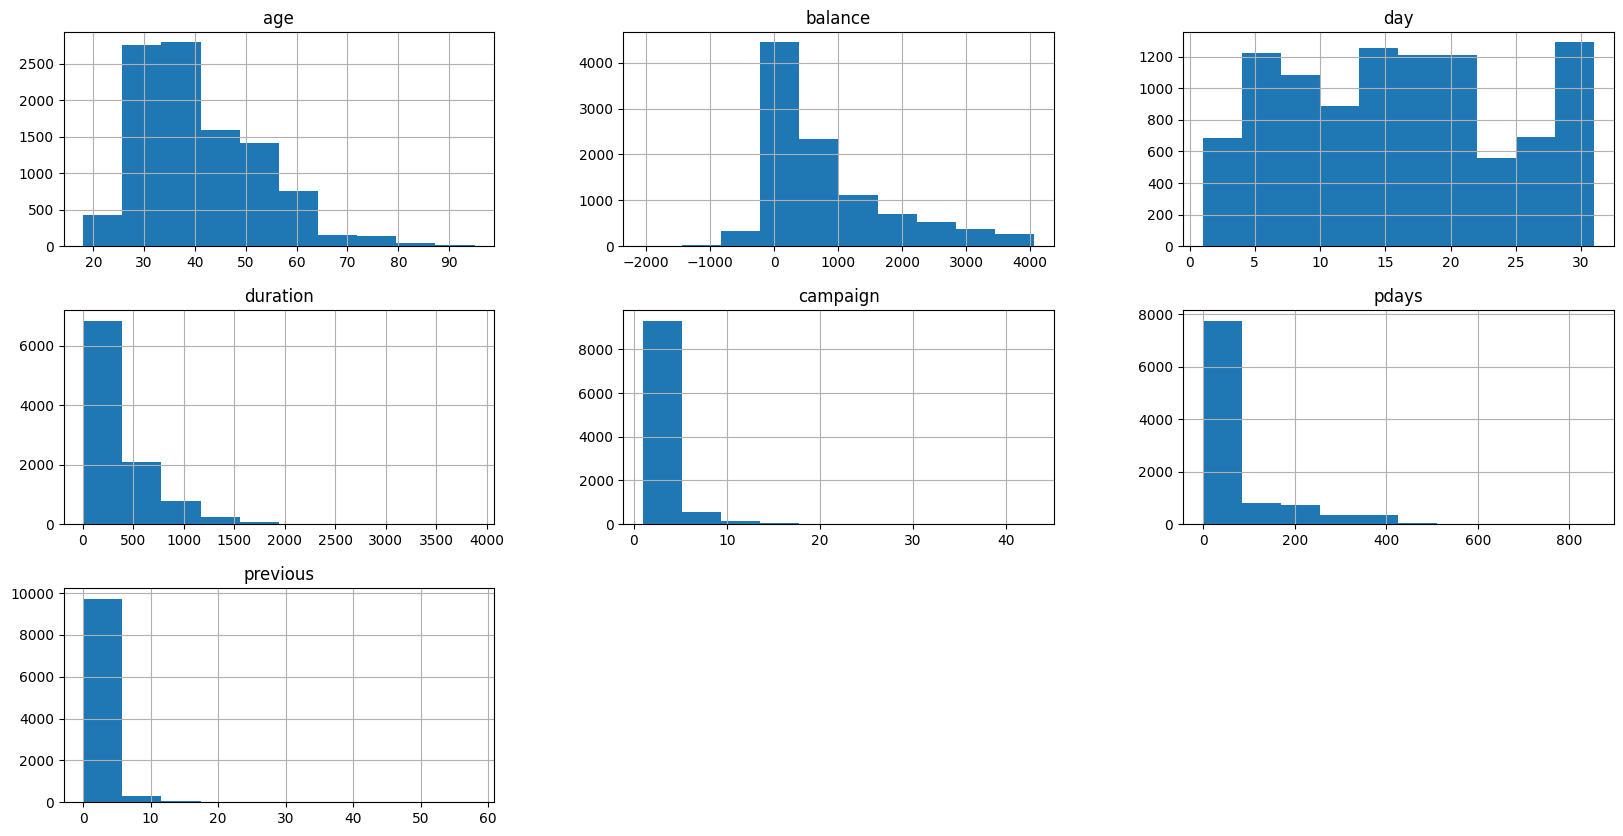

In [17]:
# Рассмотрим распределения наших числовых признаков.
df_non_emissions.hist(figsize=(20,10));

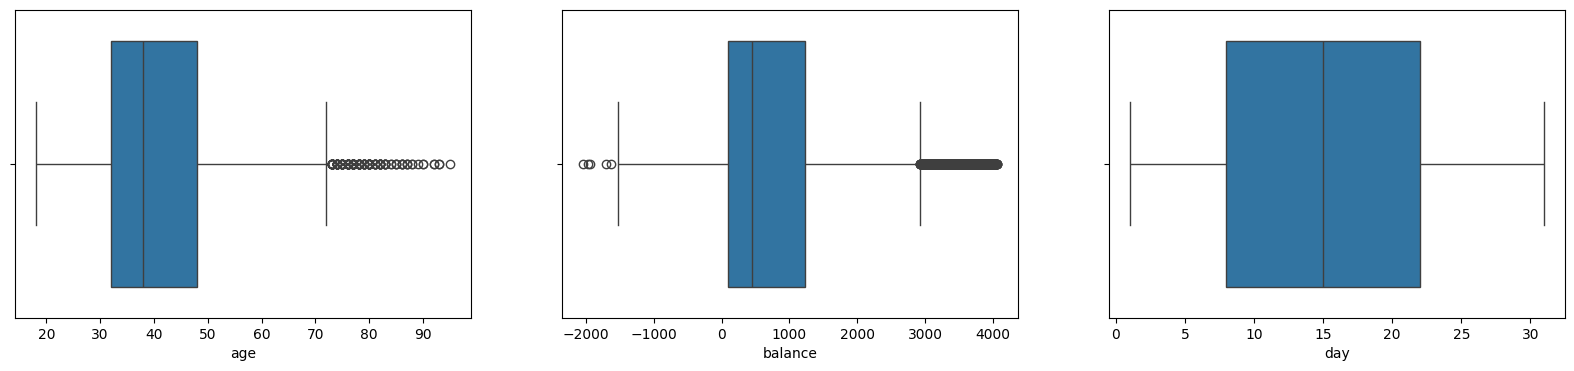

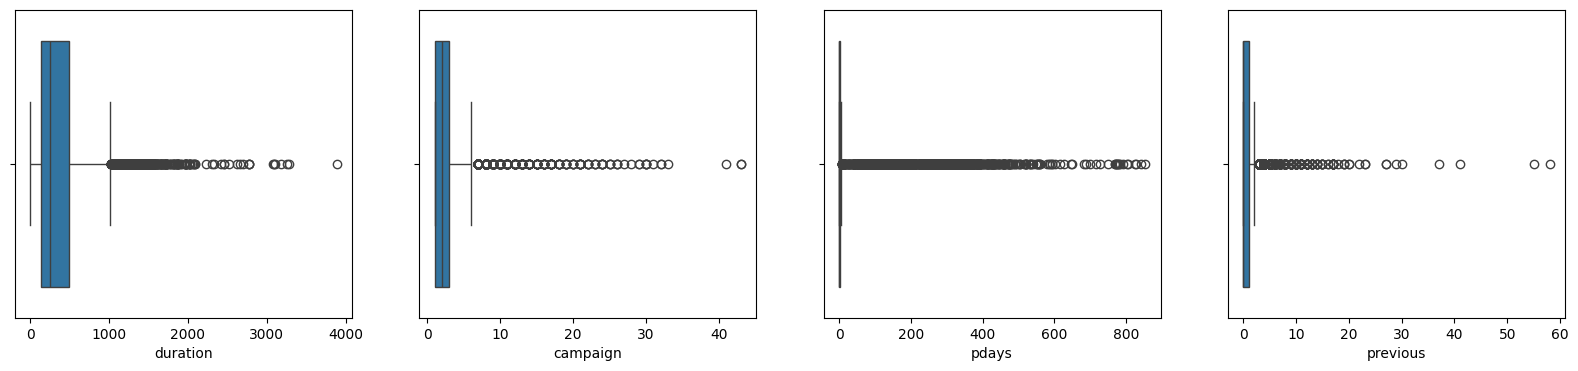

In [18]:
fig,ax1=plt.subplots(1,3,figsize=(20,4))
for num,col in enumerate(numerical_features[:3]):
    sns.boxplot(df_non_emissions[col],ax=ax1[num],orient='h')

fig,ax2=plt.subplots(1,4,figsize=(20,4))
for num,col in enumerate(numerical_features[3:]):
    sns.boxplot(df_non_emissions[col],ax=ax2[num],orient='h')



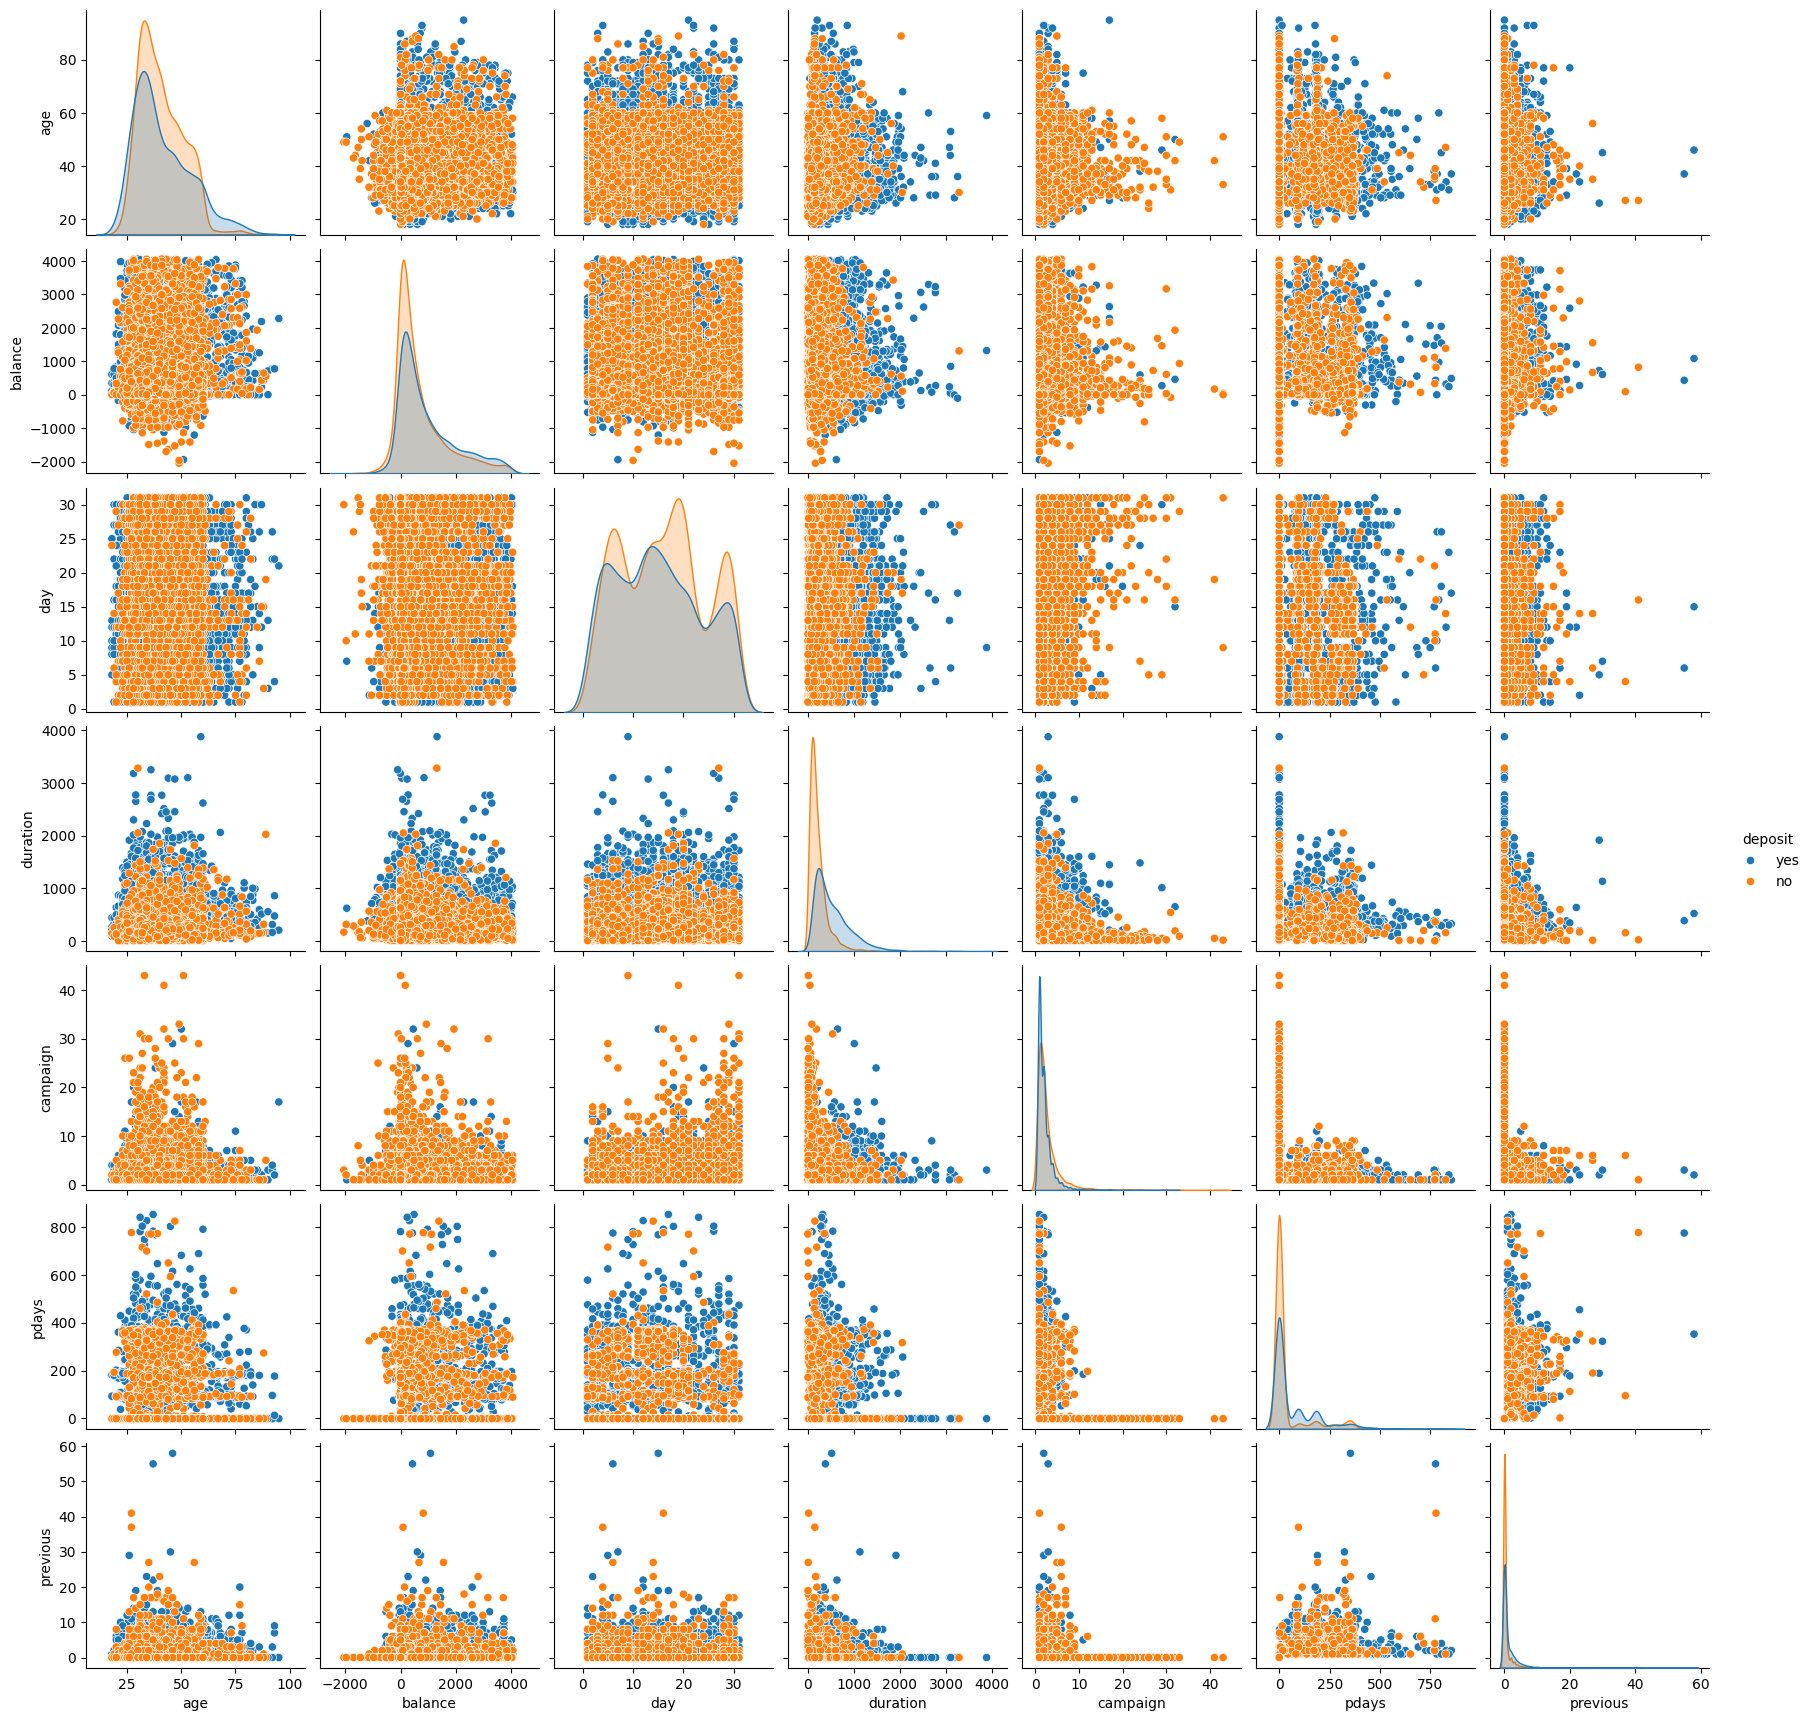

In [19]:
sns.pairplot(df_non_emissions,hue='deposit');

И так, что мы можем увидеть на графиках и какие сделать для себя выводы:
* Средний возраст клиентов 40 лет, большенство парнеров банка это люди от 32 до 48. Минимальный возраст 18 лет, а максимальный 95. Данные распределены более менее нормально. Есть выбросы.
* Баланс клиентов в среднем  807 долларов, но есть и отрицательные цифры. В основном данные сосредоточены от -2049 до 1227, поэтому тут лучше считать медиану 445 долларов. Так же есть выбросы.
* Средняя продолжительность разговора оператора с клиентов составляет 368 сек. Но тут есть выбросы, т.к. разговор в 2 сек. очень странный результат. У нас в основном все наши звонки находятся между 137 сек и 490, поэтому все, что меньше и больше этих значений можно считать выбросам.

### Задания 4 и 5

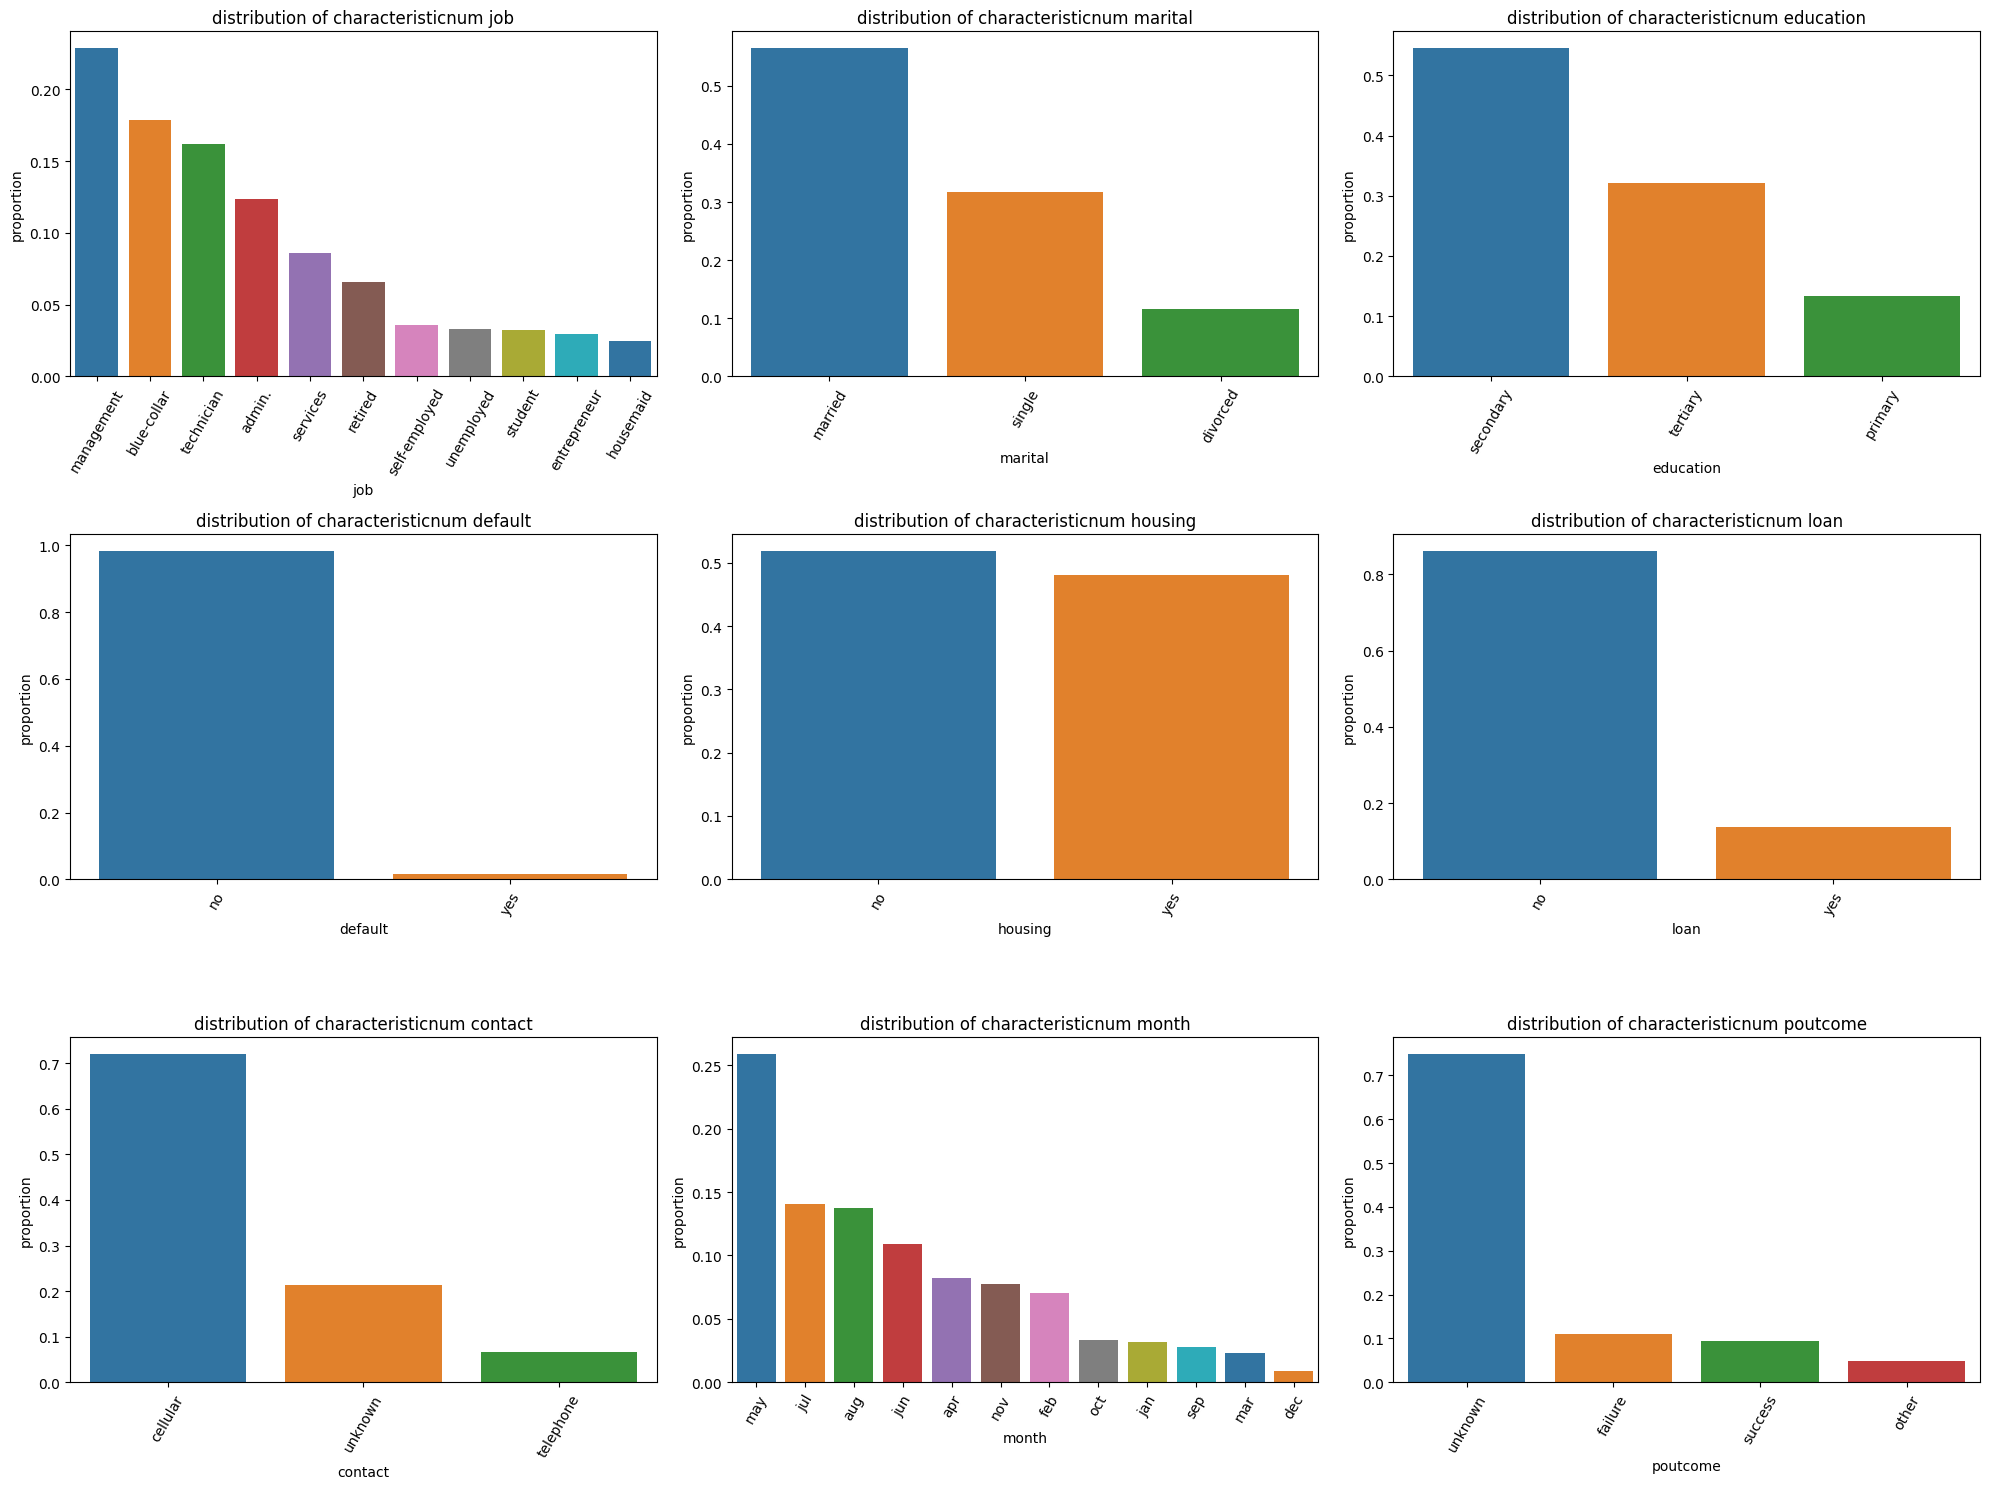

In [20]:
fig,ax1=plt.subplots(3,3,figsize=(20,15))
n=0
s=0

for col in categorical_features:
    
    if n != 3:   
        data=df_non_emissions[col].value_counts(normalize=True,sort=True).reset_index()
        sns.barplot(data,x=col,y='proportion',ax=ax1[s][n],palette='tab10')
        ax1[s][n].set_title('distribution of characteristicnum ' + col )   
        ax1[s][n].xaxis.set_tick_params(rotation=60)
        n +=1
        
    else:
        n=0
        s+=1
        data=df_non_emissions[col].value_counts(normalize=True,sort=True).reset_index()
        sns.barplot(data,x=col,y='proportion',ax=ax1[s][n],palette='tab10')
        ax1[s][n].set_title('distribution of characteristicnum ' + col )   
        ax1[s][n].xaxis.set_tick_params(rotation=60)
        n+=1
        
plt.tight_layout() #выравнивание графиков

Выводы, которые можно сделать из графиков выше:
* Самая популярная сфера деятельности - Management;
* Большенство людей женаты, потом идут одиночки и следом люди, которые развелись;
* Видим, что чаще всего встречаются люди, у кого среднее образование;
* Практически у всех нет просроченных кредитов;
* Половина имеют ипотеку;
* Мало, кто берет кредит на личные нужны;
* В основном связываются по сотовому с клиентом;
* Самый частый месяц встречается май, когда с клиентом банка последний раз связывались.
* И результат последней маркетинговой компании самый популярный это - unknown.

### Задание 6

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_non_emissions.groupby('poutcome')['deposit'].value_counts(normalize=True).round(2).reset_index()



,poutcome,deposit,proportion
0,failure,no,0.51
1,failure,yes,0.49
2,other,yes,0.55
3,other,no,0.45
4,success,yes,0.91
5,success,no,0.09
6,unknown,no,0.60
7,unknown,yes,0.40


И мы видим, что 91% парнеров, кто участвовал в прошлой маркетинговой программе, открыли депозиты в текущем промо. 

### Задание 7

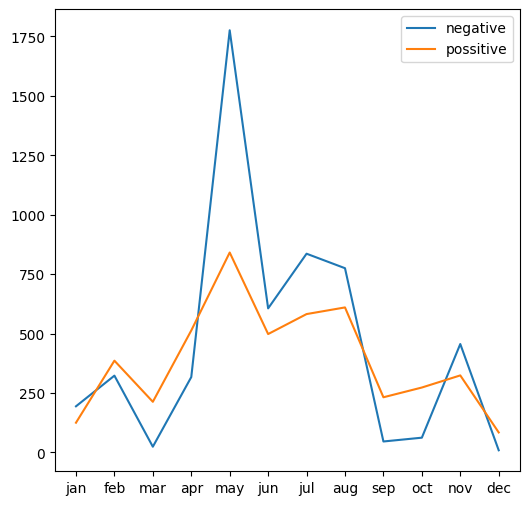

In [22]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
fig,ax=plt.subplots(figsize=(6,6))

df_month_negative=df_non_emissions[df_non_emissions['deposit']=='no'].groupby('month')['deposit'].count().rename('count').sort_values(ascending=False).reset_index()
df_month_negative['num_month']=[5,7,8,6,11,2,4,1,10,9,3,12]
df_month_negative=df_month_negative.sort_values('num_month')
ax.plot(df_month_negative['month'],df_month_negative['count'],label='negative')

df_month_possitive=df_non_emissions[df_non_emissions['deposit']=='yes'].groupby('month')['deposit'].count().rename('count').sort_values(ascending=False).reset_index()
df_month_possitive['num_month']=[5,8,7,4,6,2,11,10,9,3,1,12]
df_month_possitive=df_month_possitive.sort_values('num_month')
ax.plot(df_month_possitive['month'],df_month_possitive['count'],label='possitive')
ax.legend();

Видим, что май крайне не результативный месяц(количество отказов 1750 шт.), т.к. там много праздников и выходных. Вообще видно, что летние месяцы больше всего несут отказов в открытии депозитов, т.к. люди в отпусках и зачастую переносят все свои дела на осень.

### Задание 8

In [23]:
# разбить возраст на группы: <30,30-40,40-50,50-60,60+
df_non_emissions['age']=pd.cut(df_non_emissions['age'],bins=[0,30,40,50,60,999],labels=['<30','30-40','40-50','50-60','60+'],right=False)

In [24]:
# Необходимо узнать, какие возрастные группы чаще всего открывают депозит в текущей маркетинговой компании.
df_non_emissions.groupby('age')['deposit'].value_counts(normalize=True,ascending=False).round(2)

age    deposit
<30    yes        0.59
       no         0.41
30-40  no         0.57
       yes        0.43
40-50  no         0.61
       yes        0.39
50-60  no         0.59
       yes        0.41
60+    yes        0.76
       no         0.24
Name: proportion, dtype: float64

Две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения. Младше 30 лет и кому уже за 60

### Задания 9 и 10

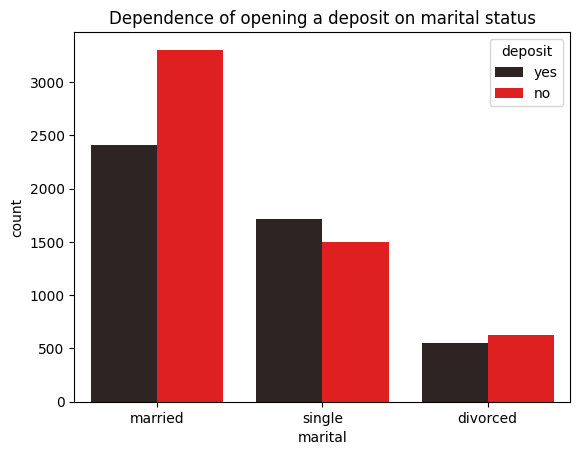

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного положения
fig=sns.countplot(data=df_non_emissions,x='marital',hue='deposit',color='r')
fig.set_title('Dependence of opening a deposit on marital status');

Положительная динамика наблюдается у категории людей, кто являются одиночками.

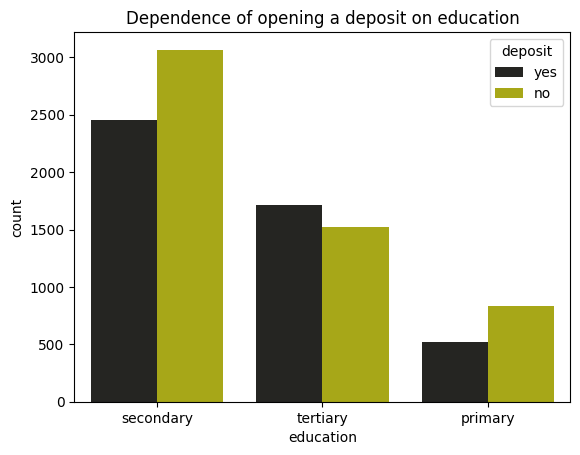

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig=sns.countplot(data=df_non_emissions,x='education',hue='deposit',color='y')
fig.set_title('Dependence of opening a deposit on education');

Высшее образование,как показывает график, влияет на открытие депозита.

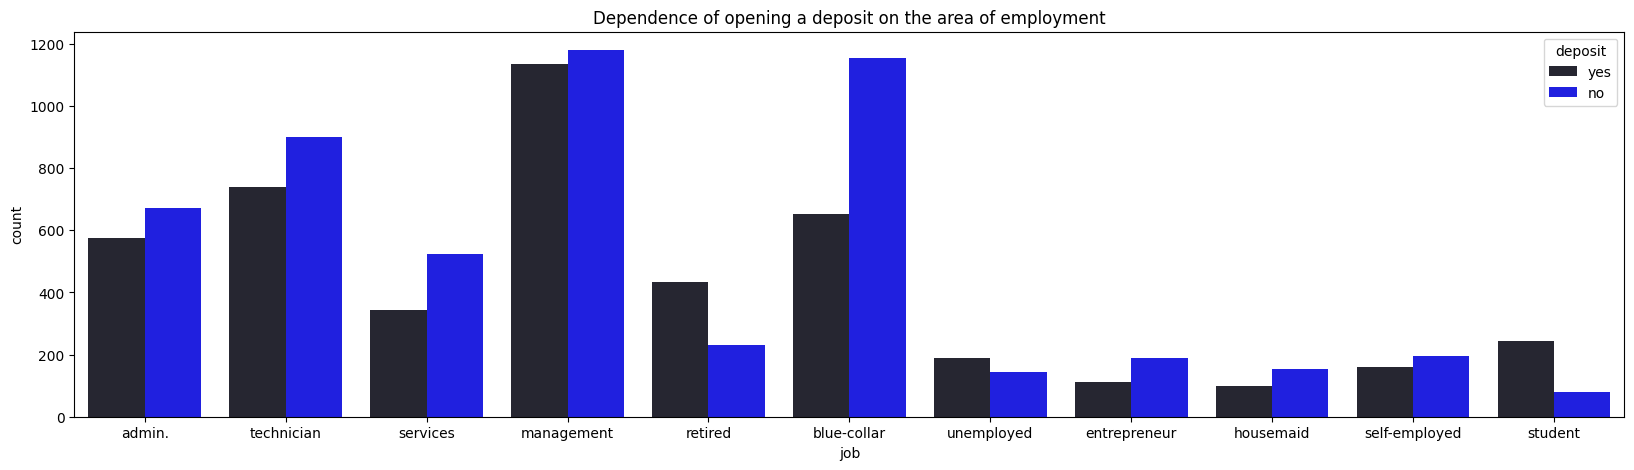

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig,ax=plt.subplots(figsize=(20,5))
fig=sns.countplot(data=df_non_emissions,x='job',hue='deposit',color='b',ax=ax)
fig.set_title('Dependence of opening a deposit on the area of ​​employment');

Как было ранее замечено, отношение клиентов, кто открыл депозит к числу отказавшишся, выше всего у студентов и людей, кто вышел на пенсию. Самое большое количество клиентов банка трудятся в сфере Management

### Задание 11

In [28]:
df_non_emissions.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,50-60,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,50-60,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,40-50,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,50-60,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,50-60,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


education,primary,secondary,tertiary
marital,,,
divorced,187,653,337
married,980,3119,1616
single,182,1745,1286


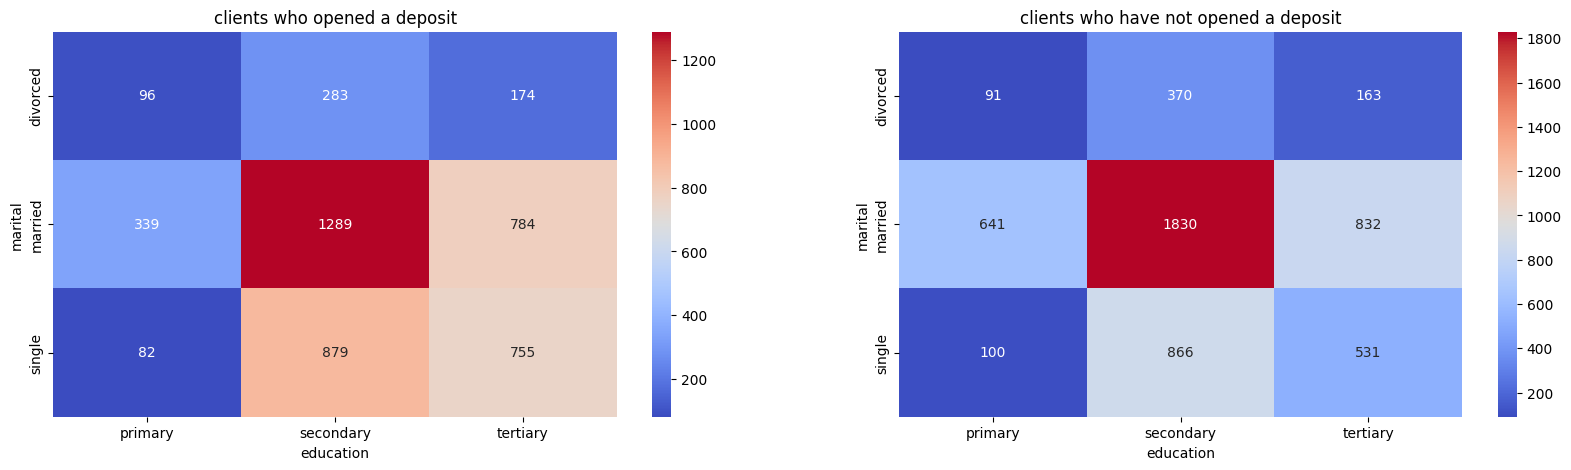

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
display(df_non_emissions.pivot_table(values='deposit',index='marital',columns='education',aggfunc='count'))

# сохраним сводную таблицу в переменную(сделаем маски для открывших депозит и нет)
summary_possitive=df_non_emissions[df_non_emissions['deposit']=='yes'].pivot_table(values='deposit',index='marital',columns='education',aggfunc='count')
summary_negative=df_non_emissions[df_non_emissions['deposit']=='no'].pivot_table(values='deposit',index='marital',columns='education',aggfunc='count')
fig,ax=plt.subplots(1,2,figsize=(20,5))
fig1=sns.heatmap(summary_possitive,ax=ax[0],annot=True,fmt='.4g',cmap="coolwarm")
fig2=sns.heatmap(summary_negative,ax=ax[1],annot=True,fmt='.4g',cmap="coolwarm")
fig1.set_title('clients who opened a deposit')
fig2.set_title('clients who have not opened a deposit');

И так, видим, что самое большое количество отказов и согласий на открытие депозита у клиентов, которые женаты(замужем) и имеют среднее образование. Положительная динамика видна у клиентов, кто в разводе и имеет высшее образование, одинокие люди с высшим и средним образованием.  

In [30]:
df_non_emissions.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,50-60,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,50-60,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,40-50,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,50-60,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,50-60,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


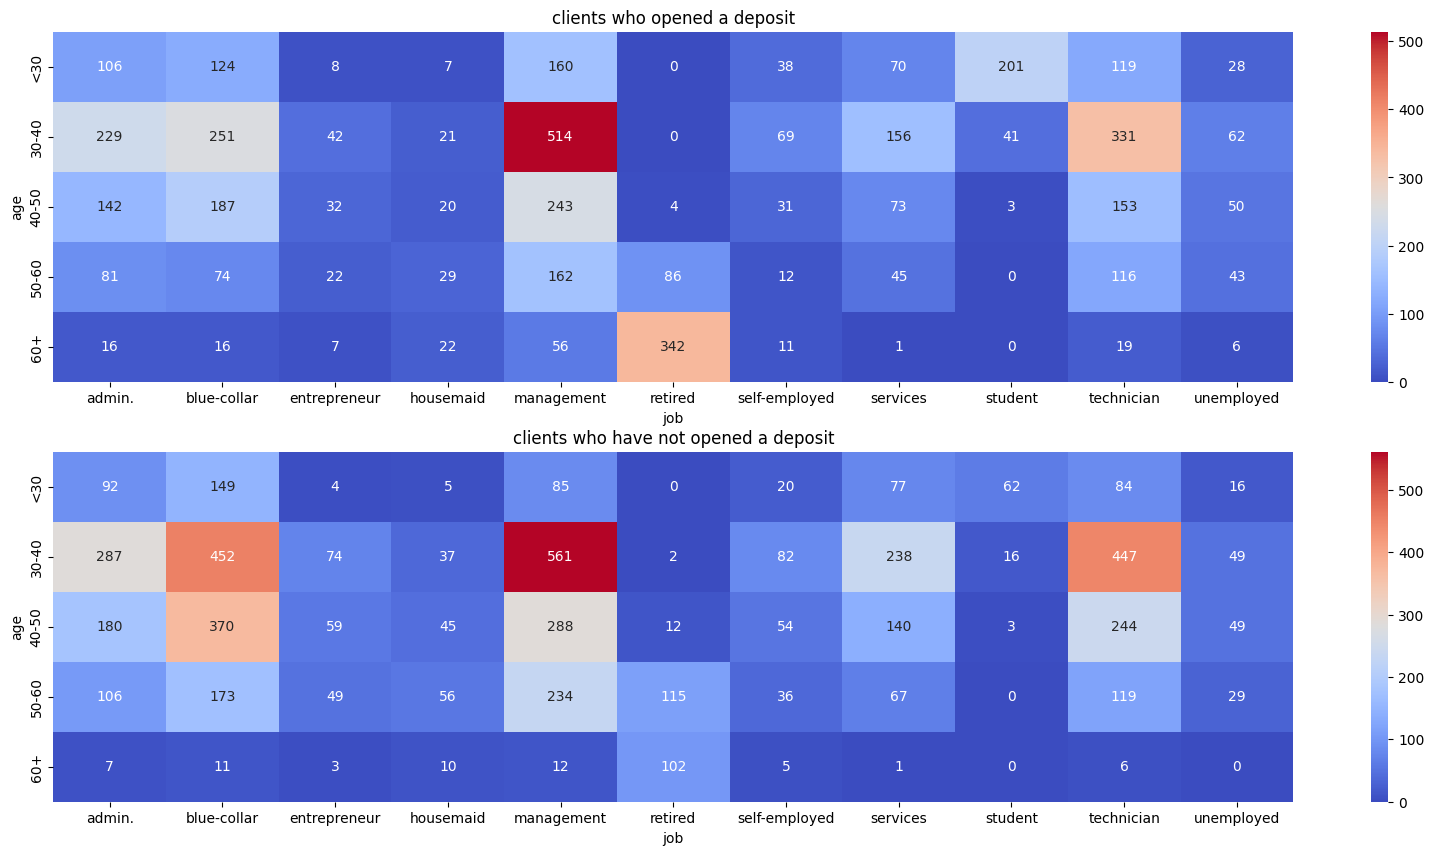

In [31]:
p=df_non_emissions[df_non_emissions['deposit']=='yes'].pivot_table(values='deposit',index='age',columns='job',aggfunc='count')
n=df_non_emissions[df_non_emissions['deposit']=='no'].pivot_table(values='deposit',index='age',columns='job',aggfunc='count')
fig,ax=plt.subplots(2,1,figsize=(20,10))
fig1=sns.heatmap(p,ax=ax[0],annot=True,fmt='.3g',cmap="coolwarm")
fig2=sns.heatmap(n,ax=ax[1],annot=True,fmt='.3g',cmap="coolwarm")
fig1.set_title('clients who opened a deposit')
fig2.set_title('clients who have not opened a deposit');

А если смотреть в разрезе возраст и вид деятельности, то тут четко видно, что высокий результат получен среди клиентов, кому уже за 60 и находятся на пенсии, а так же людям кому меньше 30. Cтуденты и начинающие менеджеры.

## Часть 3: преобразование данных

### Задание 1

In [32]:
# Скопируем наши данные для дальнейшей кодировки.
df_encoders=df_non_emissions.copy()

In [33]:
# преобразуйте уровни образования
label_encoder=LabelEncoder()
label_encoder.fit(df_encoders['education'])
df_encoders['education']=label_encoder.transform(df_encoders['education']).astype('int')


### Задания 2 и 3

In [34]:
# преобразуйте бинарные переменные в представление из нулей и единиц, в том числе и целевой признак.
label_encoder=LabelEncoder()
label_encoder.fit(df_encoders['loan'])
for col in ['loan','housing','default','deposit']:
    df_encoders[col]=label_encoder.transform(df_encoders[col]).astype('int')

### Задание 4

In [35]:
# Так же преобразуем наш признак возраст
label_encoder=LabelEncoder()
label_encoder.fit(df_encoders['age'])
df_encoders['age']=label_encoder.transform(df_encoders['age']).astype('int')


In [36]:
# Кодирование номинальных признаков. Однократное кодирование.
lst=['job','marital','contact','month','poutcome']
df_encoders=pd.get_dummies(df_encoders,columns=lst,dtype='int')


### Задания 5 и 6

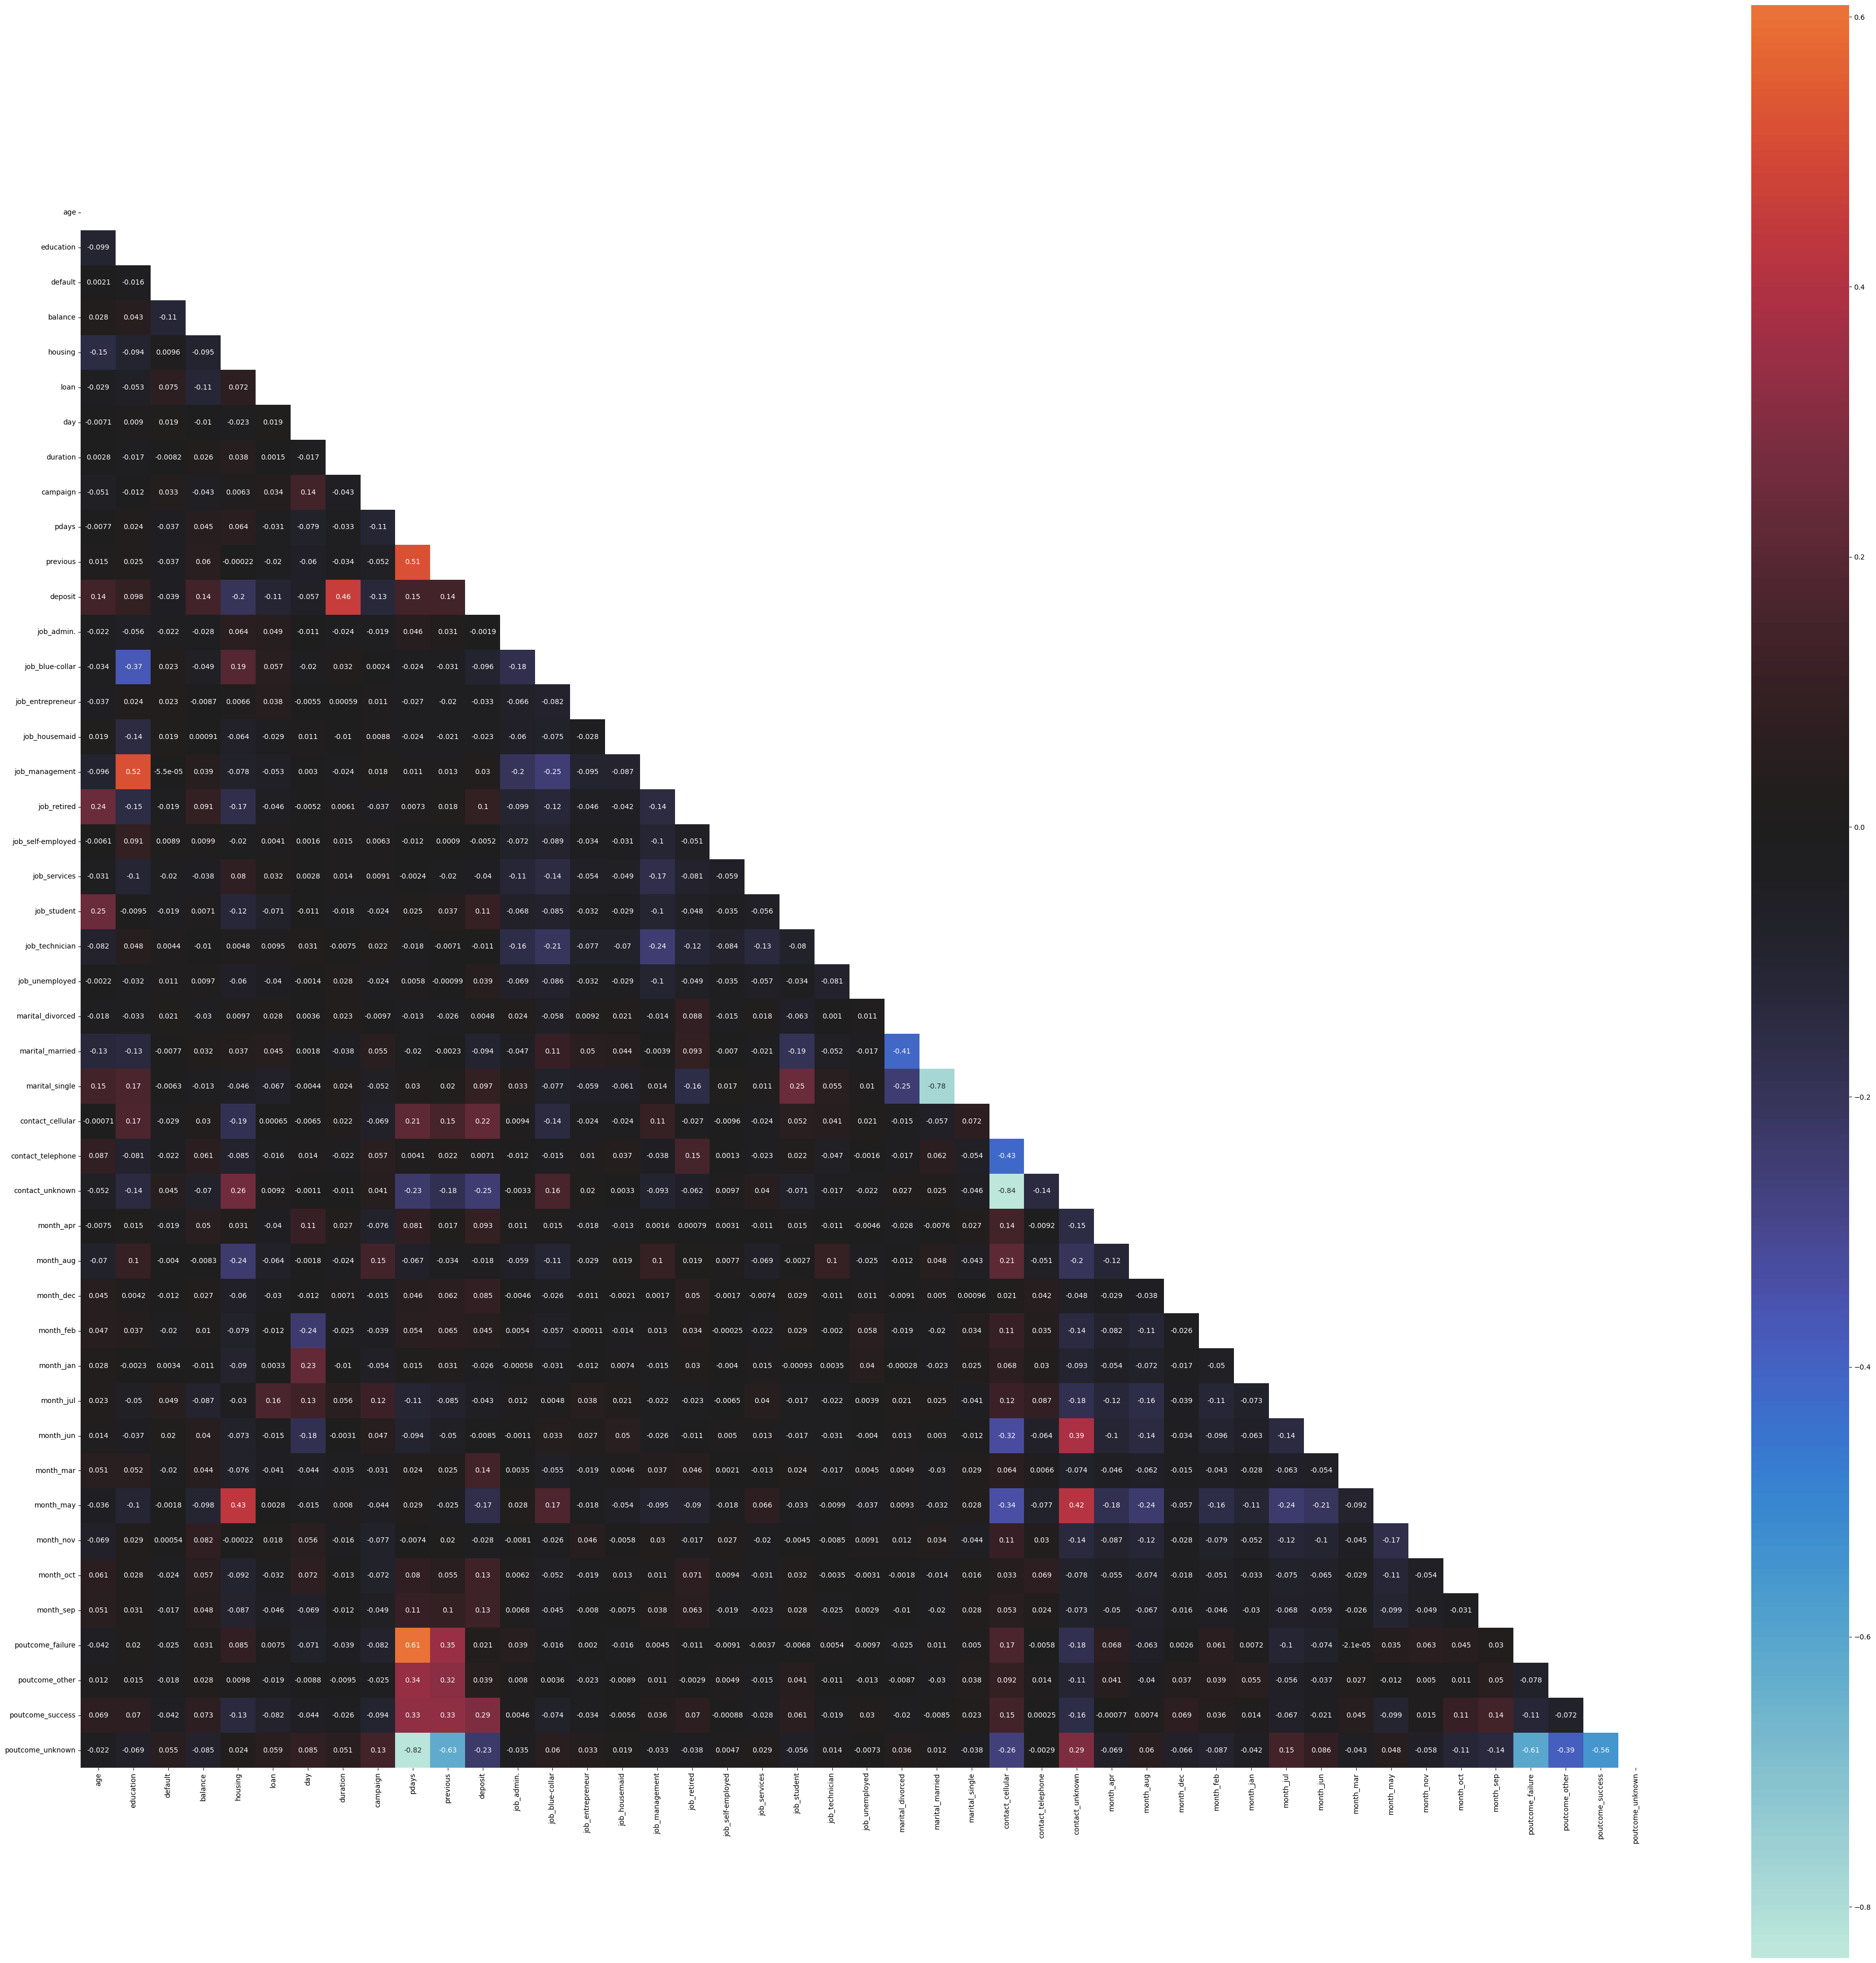

In [37]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
matrix=np.triu(df_encoders.corr())
fig,ax=plt.subplots(figsize=(50,50))
sns.heatmap(df_encoders.corr(), mask=matrix,center=0,ax=ax,annot=True,square=True);


duration            0.457818
poutcome_success    0.288491
contact_unknown     0.249294
poutcome_unknown    0.228300
contact_cellular    0.223944
Name: deposit, dtype: float64

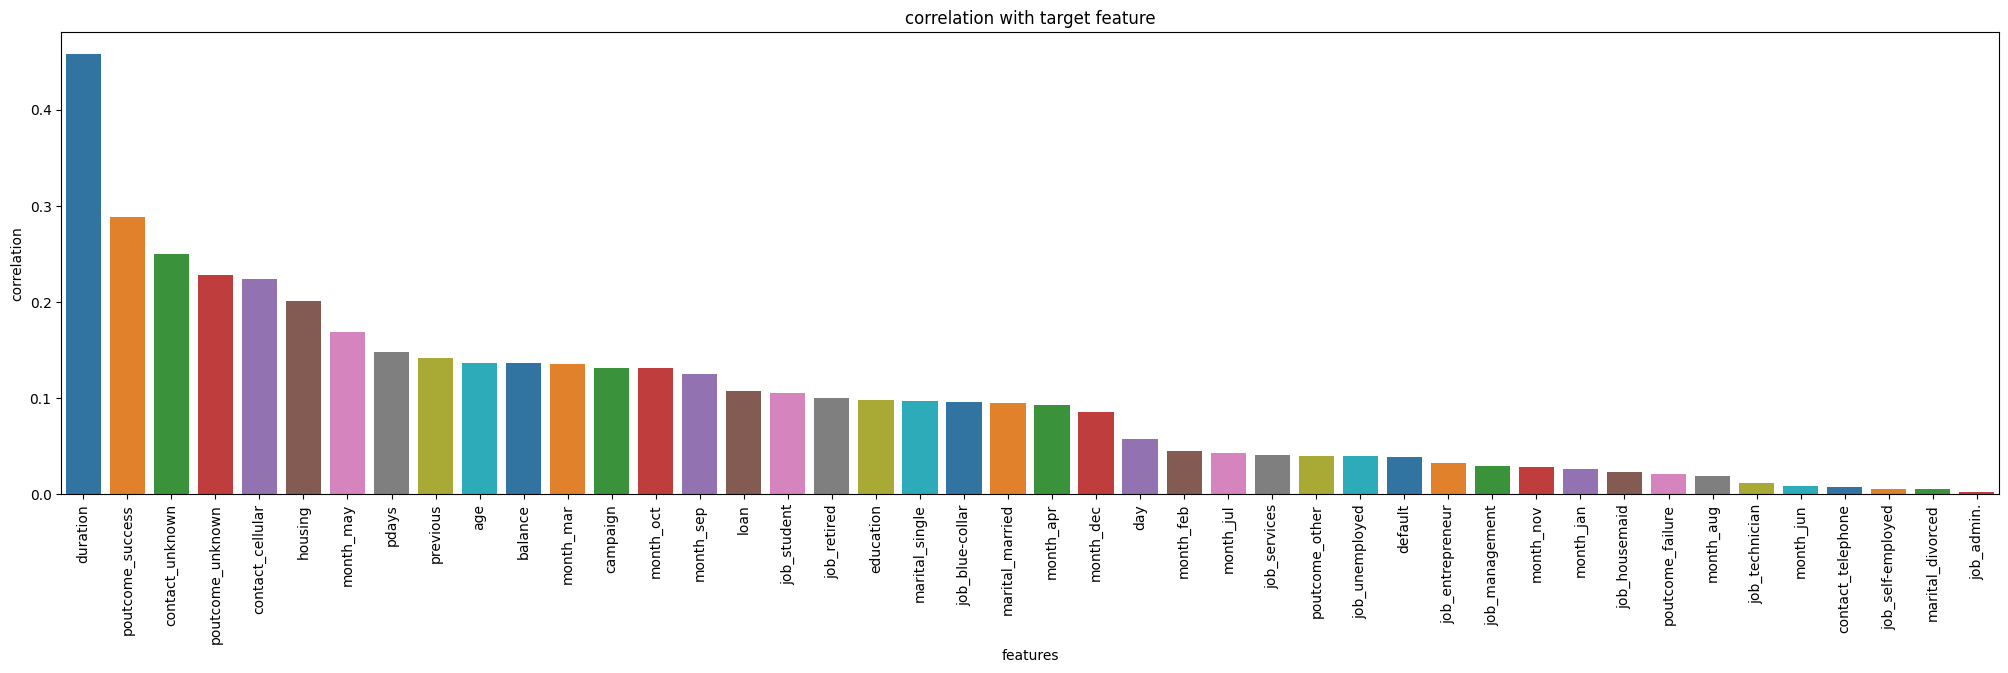

In [38]:
# Рассмотрим корреляцию непосредственно с целевым признаком. 
mask=df_encoders.corr()['deposit'].abs().sort_values(ascending=False).drop(['deposit'],axis=0)
display(mask.head())
fig,ax=plt.subplots(figsize=(25,6))
sns.barplot(mask.reset_index(),x='index',y='deposit',ax=ax,palette='tab10')
ax.set_title('correlation with target feature')
ax.set_xlabel('features')
ax.set_ylabel('correlation');
ax.xaxis.set_tick_params(rotation=90)

Видим, что критичной цифры нет. Самый высокий показатель имеется с признаком duraction

### Задания 7 и 8

In [39]:
X = df_encoders.drop(['deposit'], axis=1)
y = df_encoders['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [40]:
print(f'Размер тренировочной выборки данных:{X_train.shape}')
print(f'Размер тестовой выборки данных:{X_test.shape}')
print('---------------------------------------------------')
print(f'Сбалансированность тренировочной выборки данных: {y_train.value_counts(normalize=True).round(2)}')
print('---------------------------------------------------')
print(f'Сбалансированность тестовой выборки данных: {y_test.value_counts(normalize=True).round(2)}')

Размер тренировочной выборки данных:(6770, 44)
Размер тестовой выборки данных:(3335, 44)
---------------------------------------------------
Сбалансированность тренировочной выборки данных: deposit
0    0.54
1    0.46
Name: proportion, dtype: float64
---------------------------------------------------
Сбалансированность тестовой выборки данных: deposit
0    0.54
1    0.46
Name: proportion, dtype: float64


### Задание 9

In [41]:
#Создаем модель
model=SelectKBest(score_func=f_classif,k=15)  
# Обучаем ее на тренировочных данных
new=model.fit(X_train,y_train)
# Применяем к тренировочной выборке
new_train=new.transform(X_train)
# Новый данные уже записываем в тренировочные и тестовые переменные
df_15_train=pd.DataFrame(new_train, columns=model.get_feature_names_out()) 
df_15_test=X_test[model.get_feature_names_out()]
df_15_test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, 3333 to 3818
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3335 non-null   int64  
 1   balance           3335 non-null   float64
 2   housing           3335 non-null   int64  
 3   duration          3335 non-null   int64  
 4   campaign          3335 non-null   int64  
 5   pdays             3335 non-null   int64  
 6   previous          3335 non-null   int64  
 7   contact_cellular  3335 non-null   int64  
 8   contact_unknown   3335 non-null   int64  
 9   month_mar         3335 non-null   int64  
 10  month_may         3335 non-null   int64  
 11  month_oct         3335 non-null   int64  
 12  month_sep         3335 non-null   int64  
 13  poutcome_success  3335 non-null   int64  
 14  poutcome_unknown  3335 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 416.9 KB


Оставили лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.Таких у нас  15

### Задание 10

In [42]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn import preprocessing
# записываем в переменную названия столбцов
col=df_15_train.columns
#обучаем модель
Min_Max_Scaler=preprocessing.MinMaxScaler()
Min_Max_Scaler.fit(df_15_train)
#применяем обученную модель уже на наши данные
df_15_Scaler_train=Min_Max_Scaler.transform(df_15_train)
df_15_Scaler_test=Min_Max_Scaler.transform(df_15_test)
# переделываем в Датафрейм
df_15_Scaler_train=pd.DataFrame(df_15_Scaler_train,columns=col)
df_15_Scaler_test=pd.DataFrame(df_15_Scaler_test,columns=col)



In [43]:
display(df_15_Scaler_train.head(2))
df_15_Scaler_train.shape

,age,balance,housing,duration,campaign,pdays,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.0,0.426374,1.0,0.131735,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.346531,0.0,0.075793,0.0,0.240936,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(6770, 15)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [44]:
# обучите логистическую регрессию и рассчитайте метрики качества
model_log_reg=linear_model.LogisticRegression(solver='sag',max_iter=1000,random_state=42)
model_log_reg.fit(df_15_Scaler_train,y_train)
predict_lg_train=model_log_reg.predict(df_15_Scaler_train)
predict_lg_test=model_log_reg.predict(df_15_Scaler_test)

print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_lg_train)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_lg_train))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_lg_test)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_lg_test))

точность метрики accuracy на тренировочных данных:0.824
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.805
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [45]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn import tree
model_tree=tree.DecisionTreeClassifier(criterion='entropy',random_state=42)
model_tree.fit(df_15_Scaler_train,y_train)
predict_tr_train=model_tree.predict(df_15_Scaler_train)
predict_tr_test=model_tree.predict(df_15_Scaler_test)

print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_tr_train)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_tr_train))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_tr_test)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_tr_test))



точность метрики accuracy на тренировочных данных:1.000
--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.748
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 5

In [46]:
# подберите лучший параметр для глубины деревьев с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаем сетку наших параметров
grid_depth={'max_depth':[5,6,7,8,9,10,11,12,15,20,30,50,90,100]}
# применяем ее при происке параметров для модели 
gridsearch=GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42),
    param_grid=grid_depth,
    cv=5,
    n_jobs=-1
)
# обучаем на наших тренировочных данных
gridsearch.fit(df_15_Scaler_train,y_train) 
# предсказываем результаты тренировочных и тестовых данных
predict_tr_train_GS=gridsearch.predict(df_15_Scaler_train)
predict_tr_test_GS=gridsearch.predict(df_15_Scaler_test)
# Выводим значения метрик
print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_tr_train_GS)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_tr_train_GS))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_tr_test_GS)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_tr_test_GS))
print('--------------------------------------------------------')
print('лучшие парамерты для данной модели:{}'.format(gridsearch.best_estimator_))
print('--------------------------------------------------------')
print('наилучшее значение точности при кросс-валидации:{:.2f}'.format(gridsearch.best_score_))

точность метрики accuracy на тренировочных данных:0.836
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.818
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

--------------------------------------------------------
лучшие пара

Попробуем еще варианты подбора параметров для данной модели.

In [47]:
# Задаем снова сетку параметров
grid_split_depth={'min_samples_split': [2, 5, 7, 10],
                  'max_depth':[3,5,7]}
# используем это в поисках лучших параметров для нашей модели
gridsearch_split_depth=GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42),
    param_grid=grid_split_depth,
    n_jobs=-1,
    cv=5    
)
# Обучаем нашу модель на тренировочных данных
gridsearch_split_depth.fit(df_15_Scaler_train,y_train)
# предсказываем результаты тренировочных и тестовых данных
prct_tr_train_GS_sd=gridsearch_split_depth.predict(df_15_Scaler_train)
prct_tr_test_GS_sd=gridsearch_split_depth.predict(df_15_Scaler_test)
# Выводим значения метрик
print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,prct_tr_train_GS_sd)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,prct_tr_train_GS_sd))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,prct_tr_test_GS_sd)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,prct_tr_test_GS_sd))
print('--------------------------------------------------------')
print('лучшие парамерты для данной модели:{}'.format(gridsearch_split_depth.best_estimator_))
print('--------------------------------------------------------')
print('наилучшее значение точности при кросс-валидации:{:.2f}'.format(gridsearch_split_depth.best_score_))


точность метрики accuracy на тренировочных данных:0.836
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.818
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

--------------------------------------------------------
лучшие пара

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [48]:
# обучите на ваших данных случайный лес
model_Random_Tree=ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

model_Random_Tree.fit(df_15_Scaler_train,y_train)

predict_RT_train=model_Random_Tree.predict(df_15_Scaler_train)
predict_RT_test=model_Random_Tree.predict(df_15_Scaler_test)
# Выводим значения метрик
print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_RT_train)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_RT_train))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_RT_test)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_RT_test))


точность метрики accuracy на тренировочных данных:0.856
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.827
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [49]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier

GBC_model=GradientBoostingClassifier(learning_rate=0.05,
                                     n_estimators=100,
                                     min_samples_leaf=5,
                                     max_depth=5,
                                     random_state=42)

GBC_model.fit(df_15_Scaler_train,y_train)

predict_GBC_train=GBC_model.predict(df_15_Scaler_train)
predict_GBC_test=GBC_model.predict(df_15_Scaler_test)
# Выводим значения метрик
print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_GBC_train)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_GBC_train))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_GBC_test)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_GBC_test))


точность метрики accuracy на тренировочных данных:0.858
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.826
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



И так сравним две модели на тестовой выборке данных:
* Основанная на беггинге RandomForest. Параллельно обучаем множество одинаковых моделей, а для предсказания берём среднее по предсказаниям каждой из моделей
* Основанная на бустинге GradientBoostingClassifier. Последовательно обучаем множество одинаковых моделей, где каждая новая модель концентрируется на тех примерах, где предыдущая допустила ошибку.

In [50]:
print(metrics.classification_report(y_test,predict_RT_test))
print('--------------------------------------------------------------')
print(metrics.classification_report(y_test,predict_GBC_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модели практически одинаковые.

### Задание 4

In [51]:
# объедините уже известные вам алгоритмы с помощью стекинга 

from sklearn.ensemble import StackingClassifier

models=[('log_model',linear_model.LogisticRegression(solver='sag',max_iter=1000,random_state=42)),
        ('Tree_model',tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=7,random_state=42)),
        #('RandomF_model',ensemble.RandomForestClassifier(n_estimators=100,criterion='gini',min_samples_leaf=5,max_depth=10,random_state=42)),
        ('GBC_model',GradientBoostingClassifier(learning_rate=0.05,n_estimators=100,min_samples_leaf=5,max_depth=5,random_state=42))]

Stack_model=StackingClassifier(estimators=models,
                               final_estimator=linear_model.LogisticRegression())


Stack_model.fit(df_15_Scaler_train,y_train)

predict_Stack_train=Stack_model.predict(df_15_Scaler_train)
predict_Stack_test=Stack_model.predict(df_15_Scaler_test)

print('точность метрики accuracy на тренировочных данных:{:.3f}'.format(metrics.accuracy_score(y_train,predict_Stack_train)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_train,predict_Stack_train))
print('--------------------------------------------------------')
print('точность метрики accuracy на тестовых данных:{:.3f}'.format(metrics.accuracy_score(y_test,predict_Stack_test)))
print('--------------------------------------------------------')
print(metrics.classification_report(y_test,predict_Stack_test))

точность метрики accuracy на тренировочных данных:0.854
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3634
           1       0.84      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

--------------------------------------------------------
точность метрики accuracy на тестовых данных:0.825
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 5

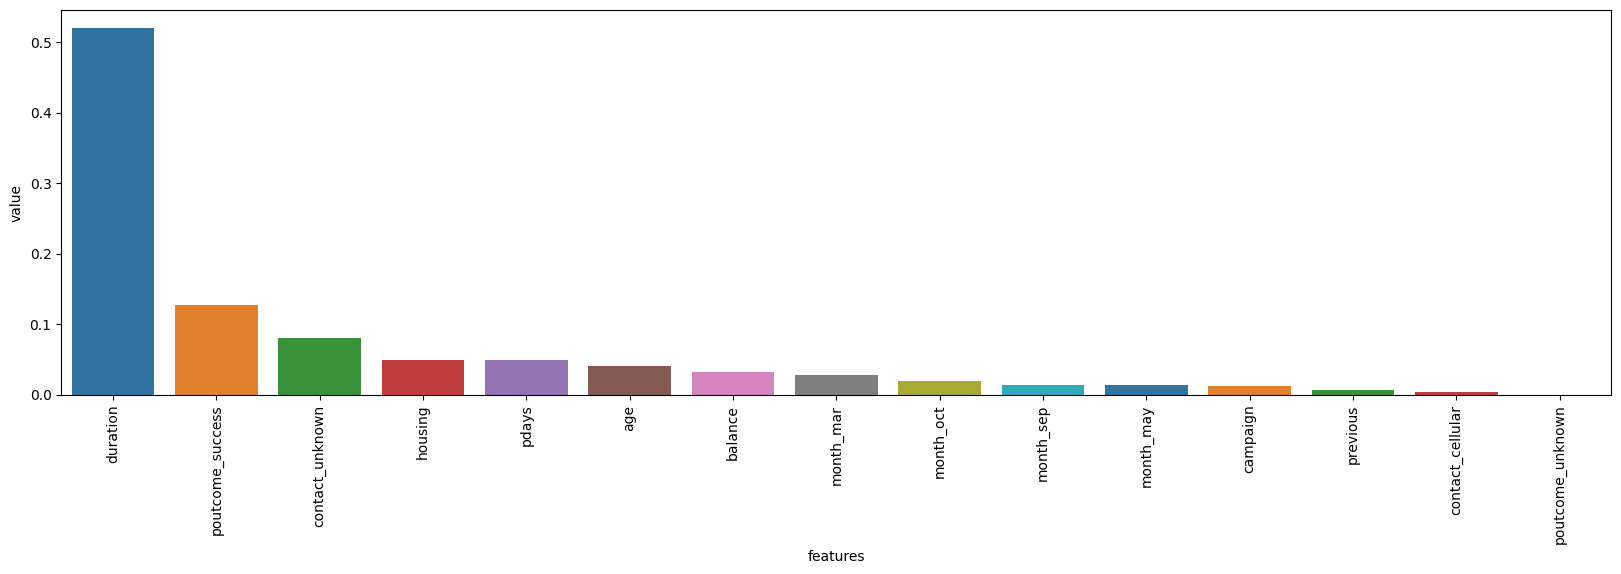

In [52]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
mask=pd.DataFrame({'features':GBC_model.feature_names_in_,'value':GBC_model.feature_importances_}).sort_values(by='value',ascending=False)

fig,ax=plt.subplots(figsize=(20,5))
sns.barplot(x=mask.features,y=mask.value,palette='tab10',ax=ax);
ax.xaxis.set_tick_params(rotation=90)

Порядок важности признаков для нашей модели практически схож с корреляцией  для целевого вектора. Получается, что для прогноза положительного решения клиента открыть депозит в банке
* На первом месте влияет время его общения с оператором, чем больше клиент общается, тем больше вероятность положительно ответа, так и есть в жизни.
* Результат прошлого промо мероприятия, люди, кто уже участвовал в акциях, охотнее соглашаются на новую.
* И третий важный признак, это связь с клиентом, большенство людей сами находили информацию об акции, без участия оператора банка.

### Задания 6,7,8

In [53]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# вызов библиотеки
import optuna
# создаем функцию с нашими данными
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # обучаем модель
    model.fit(df_15_Scaler_train,y_train)
    score = metrics.f1_score(y_train, model.predict(df_15_Scaler_train))
    return score
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study=optuna.create_study(study_name='RandomForestClassifier',direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

# выводим результаты на обучающей выборке
print(study.best_params) # Наилучшие значения гиперпараметров 
print(study.best_value) # "f1_score на обучающем наборе


[I 2024-10-03 14:03:50,019] A new study created in memory with name: RandomForestClassifier
[I 2024-10-03 14:03:51,366] Trial 0 finished with value: 0.859643638637074 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.859643638637074.
[I 2024-10-03 14:03:53,169] Trial 1 finished with value: 0.8569192235441453 and parameters: {'n_estimators': 157, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.859643638637074.
[I 2024-10-03 14:03:54,547] Trial 2 finished with value: 0.8937363664693051 and parameters: {'n_estimators': 124, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8937363664693051.
[I 2024-10-03 14:03:55,869] Trial 3 finished with value: 0.8588861076345432 and parameters: {'n_estimators': 137, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8937363664693051.
[I 2024-10-03 14:03:57,719] Trial 4 finished with value: 0.8622305529522024 and parameters: {'n_est

{'n_estimators': 146, 'max_depth': 26, 'min_samples_leaf': 2}
0.9256534668962279


In [54]:
model = ensemble.RandomForestClassifier(**study.best_params)
model.fit(df_15_Scaler_train, y_train)
y_train_pred = model.predict(df_15_Scaler_train)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train,y_train_pred)))
y_test_pred = model.predict(df_15_Scaler_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

f1_score на тренировочном наборе: 0.92
f1_score на тестовом наборе: 0.82
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [55]:
# Проверим, можно ли сделать визуализацию
optuna.visualization.is_available()  # True or False 

True

In [56]:
# понять идет ли рост метрики с увеличением итераций
optuna.visualization.plot_optimization_history(study, target_name="f1_score") 

<center><img src=1.png length=10000 height=400>

Заметно, что после определенного значения Trial повторов, значение метрики F1 перестала расти и зафиксировалась на 0.925983

In [57]:
# какие параметры важные самые.
optuna.visualization.plot_param_importances(study, target_name="f1_score") 



<center><img src=2.png length=10000 height=400>

In [58]:
# Визуализация 
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

<center><img src=3.png length=10000 height=400>

На графике видим, что максимальные значения достигаются в разных областях. Разница лишь в сотых долях.
И так с помощью оптимизации гиперпараметров нам удалось немного улучшить качество нашей модели, подняв на один пункт метрику f1.